In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob
from decimal import Decimal
from eofs.xarray import Eof
from bin_functions import bin_TS
from eof_functions import compute_eof, proj_on_eof
from drift_functions import lag_linregress_3D

In [5]:
plt.style.use('ggplot')

In [78]:
# -- Read historical run
data = '/data/ysilvy/CMIP5_annual/4D/'
Sr2 = xr.open_dataset(data+'so_Oyr_IPSL-CM5A-LR_historical-rcp85_r2i1p1_185001-210012.nc')
Tr2 = xr.open_dataset(data+'thetao_Oyr_IPSL-CM5A-LR_historical-rcp85_r2i1p1_185001-210012.nc')

In [82]:
# -- Read piControl from start date of historical run (1860)
SpiC = xr.open_mfdataset(sorted(glob.glob(data+'so*piControl*.nc'))[0:6],combine='by_coords',data_vars='minimal',coords='minimal', compat='override')
TpiC = xr.open_mfdataset(sorted(glob.glob(data+'thetao*piControl*.nc'))[0:6],combine='by_coords',data_vars='minimal',coords='minimal', compat='override')
SpiC = SpiC.sel(time=slice('1860','2110'))
TpiC = TpiC.sel(time=slice('1860','2110'))

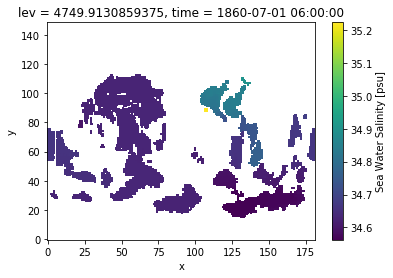

In [6]:
SpiC.so.isel(time=0,lev=-2).plot()

In [83]:
SpiC['time'] = np.arange(1860,2111)
TpiC['time'] = np.arange(1860,2111)

In [79]:
Sr2['time'] = np.arange(1860,2111)
Tr2['time'] = np.arange(1860,2111)

In [43]:
# covS,corS,slopeS,interceptS,pvalS,stderrS = lag_linregress_3D(x=SpiC.time,y=SpiC.so.isel(x=75,y=30,lev=25))         

## Average bottom waters to diagnose drift

In [9]:
# -- Read volume (same for all experiments with IPSLCM5)
dirvol = '/bdd/CMIP5/output/IPSL/IPSL-CM5A-LR/piControl/fx/ocean/fx/r0i0p0/latest/volcello/'
dsvol = xr.open_dataset(dirvol+'volcello_fx_IPSL-CM5A-LR_piControl_r0i0p0.nc')
dsvol = dsvol.reindex(lev=list(TpiC.lev))
dsvol = dsvol.drop('j')
dsvol = dsvol.drop('i')
dsvol = dsvol.rename({'j': 'y','i': 'x'})

In [23]:
Tbottom = TpiC.thetao.isel(lev=slice(24,31))
vol = dsvol.volcello.isel(lev=slice(24,31)).where(~np.isnan(Tbottom.isel(time=0)))

In [24]:
Tbot_m = ((Tbottom*vol).sum(dim=('lev','y','x')))/(vol.sum(dim=('lev','y','x')))

In [25]:
Tbot_m = Tbot_m.load()

In [26]:
regT = lag_linregress_3D(x=Tbot_m.time,y=Tbot_m) 
Tdrift_bot = Tbot_m.time*regT[2]+regT[3]

In [27]:
Tbot_dedrift = Tbot_m - Tdrift_bot + Tbot_m.mean()

In [28]:
Tbottom_r2 = Tr2.thetao.isel(lev=slice(24,31))
Tbot_m_r2 = ((Tbottom_r2*vol).sum(dim=('lev','y','x')))/(vol.sum(dim=('lev','y','x')))

Tbot_m_r2 = Tbot_m_r2.load()

Tbot_dedrift_r2 = Tbot_m_r2 - Tdrift_bot + Tbot_m.mean()

Text(0.5, 1.0, 'Volume-averaged temperature below 2289m')

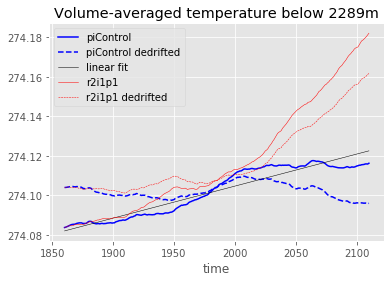

In [39]:
Tbot_m.plot(label='piControl',color='blue')
Tbot_dedrift.plot(label='piControl dedrifted',color='blue',ls='--')
Tdrift_bot.plot(label='linear fit',color='k',lw=0.5)
Tbot_m_r2.plot(label='r2i1p1',color='red',lw=0.5)
Tbot_dedrift_r2.plot(label='r2i1p1 dedrifted',color='red',ls='--',lw=0.5)
plt.legend()
plt.title('Volume-averaged temperature below %dm'%(TpiC.lev[24].data,))

In [40]:
Sbottom = SpiC.so.isel(lev=slice(24,31))
Sbot_m = ((Sbottom*vol).sum(dim=('lev','y','x')))/(vol.sum(dim=('lev','y','x')))

Sbot_m = Sbot_m.load()

In [41]:
regS = lag_linregress_3D(x=Sbot_m.time,y=Sbot_m)         

Sdrift_bot = Sbot_m.time*regS[2]+regS[3]

Sdrift_bot_cubic = np.poly1d(np.polyfit(Sbot_m.time,Sbot_m,3))

Sdrift_bot_quad = np.poly1d(np.polyfit(Sbot_m.time,Sbot_m,4))

In [44]:
Sbot_dedrift = Sbot_m - Sdrift_bot + Sbot_m.mean()

In [42]:
Sbottom_r2 = Sr2.so.isel(lev=slice(24,31))
Sbot_m_r2 = ((Sbottom_r2*vol).sum(dim=('lev','y','x')))/(vol.sum(dim=('lev','y','x')))

Sbot_m_r2 = Sbot_m_r2.load()

Sbot_dedrift_r2 = Sbot_m_r2 - Sdrift_bot + Sbot_m.mean()

Text(0.5, 1.0, 'Volume-averaged salinity below 2289m')

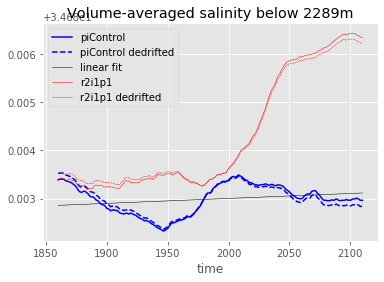

In [53]:
Sbot_m.plot(label='piControl',color='blue')
Sbot_dedrift.plot(label='piControl dedrifted',color='blue',ls='--')
Sdrift_bot.plot(label='linear fit',color='k',lw=0.5)
Sbot_m_r2.plot(label='r2i1p1',color='red',lw=0.5)
Sbot_dedrift_r2.plot(label='r2i1p1 dedrifted',color='red',ls='--',lw=0.5)
# Sdrift_bot.plot(label='linear fit')
# plt.plot(Sbot_m.time,Sdrift_bot_cubic(Sbot_m.time),label='cubic fit')
# plt.plot(Sbot_m.time,Sdrift_bot_quad(Sbot_m.time),label='quadratic fit')
plt.legend()
# plt.ylim([34.682,34.687])
ax = plt.gca()
plt.title('Volume-averaged salinity below %dm'%(TpiC.lev[24].data,))

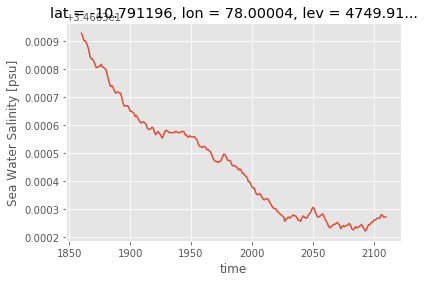

In [21]:
SpiC.so.isel(x=0,y=60,lev=-2).plot()

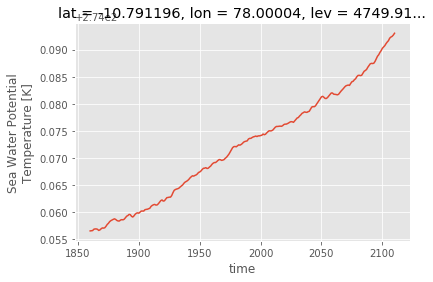

In [22]:
TpiC.thetao.isel(x=0,y=60,lev=-2).plot()

## Dedrift linearly each grid point in T and S, then bin 

In [8]:
# SpiC = SpiC.load()
# TpiC = TpiC.load()

In [11]:
covS,corS,slopeS,interceptS,pvalS,stderrS = lag_linregress_3D(x=SpiC.time,y=SpiC.so)         

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/reductions.py:408: RuntimeWarning: divide by zero encountered in true_divide
  u = total / n
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/reductions.py:408: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_di

In [12]:
covT,corT,slopeT,interceptT,pvalT,stderrT = lag_linregress_3D(x=TpiC.time,y=TpiC.thetao)   

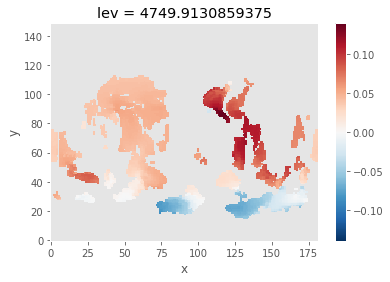

In [13]:
(slopeT.isel(lev=-2)*251).plot()

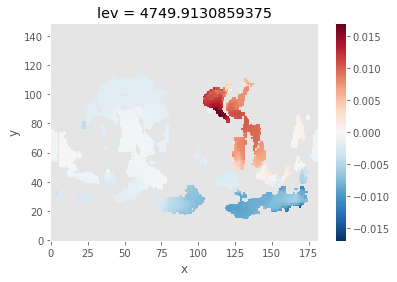

In [14]:
(slopeS.isel(lev=-2)*251).plot()

In [15]:
S_drift = SpiC.time*slopeS + interceptS
T_drift = TpiC.time*slopeT + interceptT

In [17]:
SpiC_dedrift = SpiC.so - S_drift + SpiC.so.mean(dim='time')
TpiC_dedrift = TpiC.thetao - T_drift + TpiC.thetao.mean(dim='time')

In [18]:
SpiC_dedrift

<xarray.DataArray (time: 251, lev: 31, y: 149, x: 182)>
dask.array<add, shape=(251, 31, 149, 182), dtype=float64, chunksize=(50, 31, 149, 182)>
Coordinates:
    lat      (y, x) float32 -78.19058 -78.19058 ... 50.516075 49.978893
    lon      (y, x) float32 78.00004 80.0 81.99996 ... 80.33562 80.22104 80.0
  * lev      (lev) float64 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
  * time     (time) int64 1860 1861 1862 1863 1864 ... 2106 2107 2108 2109 2110
Dimensions without coordinates: y, x

In [20]:
SpiC_dedrift = SpiC_dedrift.load()
TpiC_dedrift = TpiC_dedrift.load()

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [22]:
SpiC_dedrift = SpiC_dedrift.to_dataset(name='so')
TpiC_dedrift = TpiC_dedrift.to_dataset(name='thetao')

In [19]:
reso = [0.01,0.02,0.025,0.03,0.04,0.05,0.1]
c = 10
deltaS = reso[1]
deltaT = c*deltaS
sbins = np.arange(30,40, deltaS) 
tbins = np.arange(-2, 33, deltaT)
region='global'

In [24]:
dirvol = '/bdd/CMIP5/output/IPSL/IPSL-CM5A-LR/piControl/fx/ocean/fx/r0i0p0/latest/volcello/'
dsvol = xr.open_dataset(dirvol+'volcello_fx_IPSL-CM5A-LR_piControl_r0i0p0.nc')
dsvol = dsvol.reindex(lev=list(TpiC.lev))
dsvol = dsvol.drop('j')
dsvol = dsvol.drop('i')
dsvol = dsvol.rename({'j': 'y','i': 'x'})

In [25]:
VpiC_dedrift = bin_TS(SpiC_dedrift,TpiC_dedrift,dsvol.volcello,sbins,tbins)

In [28]:
# -- Perform EOF
solver=Eof(VpiC_dedrift.stack(z=('so_bin', 'thetao_bin')))

pcs = solver.pcs(npcs=3)
eofs = solver.eofs(neofs=3)
variance_frac = solver.varianceFraction()
var1 = variance_frac[0].data*100
var2 = variance_frac[1].data*100
var3 = variance_frac[2].data*100
total_variance = solver.totalAnomalyVariance()
eofs_st_1 = eofs[0,:].unstack('z')
eofs_st_2 = eofs[1,:].unstack('z')
eofs_st_3 = eofs[2,:].unstack('z')

levels = [-1.e-1,-1.e-2,-1.e-3,-1.e-4,-1.e-5,-1.e-6,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1]
levels_str = ['%.0E' % Decimal(str(w)) for w in levels]

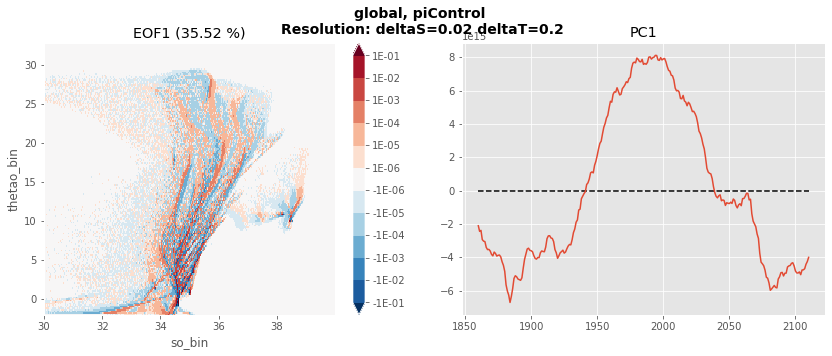

In [76]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1860,2111)

c = eofs_st_1.T.plot(ax=ax[0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[1].plot(time,pcs[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

# c = eofs_st_2.T.plot(ax=ax[1,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
# cb = fig.colorbar(c,ax=ax[1,0],label='',ticks=levels)
# cb.ax.set_yticklabels(levels_str)
# ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2))+'%)')
# ax[1,1].plot(time,pcs[:,1])
# ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
# ax[1,1].set_title('PC2')

# c = eofs_st_3.T.plot(ax=ax[2,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
# cb = fig.colorbar(c,ax=ax[2,0],label='',ticks=levels)
# cb.ax.set_yticklabels(levels_str)
# ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3))+'%)')
# ax[2,1].plot(time,pcs[:,2])
# ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
# ax[2,1].set_title('PC3')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = region+', piControl \nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT) # \n centered and reduced'

plt.suptitle(title,fontsize=14,fontweight='bold')

plt.savefig('dedrift_piC_géographique.png') #002501 #0105

In [30]:
VpiC = bin_TS(SpiC,TpiC,dsvol.volcello,sbins,tbins)

In [34]:
voltot = VpiC.isel(time=-1).sum().load()

voltot_dedrift = VpiC_dedrift.isel(time=-1).sum()

In [36]:
voltot_dedrift.data

array(1.33912882e+18)

In [38]:
voltot.data

array(1.33912697e+18)

In [39]:
diff = voltot.data-voltot_dedrift.data

In [41]:
diff/1.e09

-1848.49039872

In [42]:
voltot.data/1.e09

1339126974.2039971

In [46]:
100*diff/voltot.data

-0.0001380369773985606

### Dedrift in volume T-S 

In [48]:
covV,corV,slopeV,interceptV,pvalV,stderrV = lag_linregress_3D(x=VpiC.time,y=VpiC)   

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [ ]:
V_drift = VpiC.time*slopeV + interceptV
VpiC_dedrift_bis = VpiC - V_drift + VpiC.mean(dim='time')

In [50]:
VpiC_dedrift_bis

<xarray.DataArray (time: 251, so_bin: 499, thetao_bin: 174)>
dask.array<add, shape=(251, 499, 174), dtype=float64, chunksize=(1, 499, 174)>
Coordinates:
  * so_bin      (so_bin) float64 30.01 30.03 30.05 30.07 ... 39.93 39.95 39.97
  * thetao_bin  (thetao_bin) float64 -1.9 -1.7 -1.5 -1.3 ... 32.1 32.3 32.5 32.7
  * time        (time) int64 1860 1861 1862 1863 1864 ... 2107 2108 2109 2110

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*args2)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*args2)


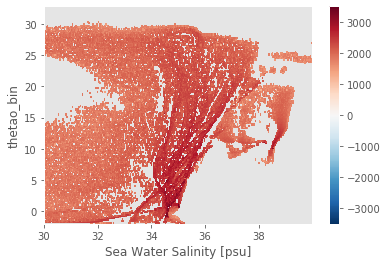

In [54]:
(251*np.log10(slopeV.T)).plot()

In [57]:
VpiC_dedrift_bis = VpiC_dedrift_bis.load()

In [58]:
# -- Perform EOF
solver2=Eof(VpiC_dedrift_bis.stack(z=('so_bin', 'thetao_bin')))

In [59]:
pcs_bis = solver2.pcs(npcs=3)
eofs_bis = solver2.eofs(neofs=3)
variance_frac_bis = solver2.varianceFraction()
var1_bis = variance_frac_bis[0].data*100
var2_bis = variance_frac_bis[1].data*100
var3_bis = variance_frac_bis[2].data*100
eofs_st_1_bis = eofs_bis[0,:].unstack('z')
eofs_st_2_bis = eofs_bis[1,:].unstack('z')
eofs_st_3_bis = eofs_bis[2,:].unstack('z')

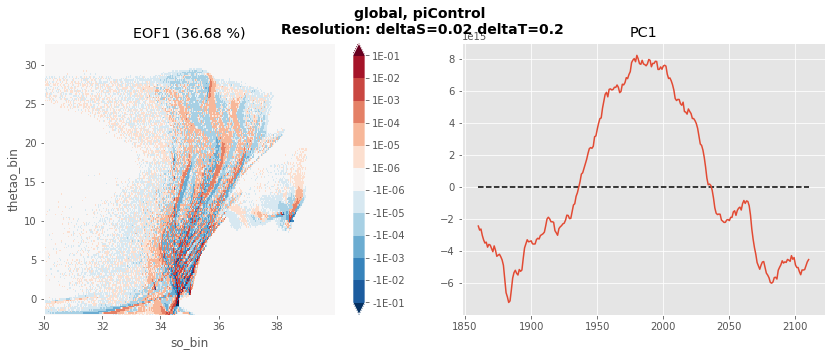

In [77]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1860,2111)

c = eofs_st_1_bis.T.plot(ax=ax[0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_bis))+'%)')
ax[1].plot(time,pcs_bis[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

# c = eofs_st_2_bis.T.plot(ax=ax[1,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
# cb = fig.colorbar(c,ax=ax[1,0],label='',ticks=levels)
# cb.ax.set_yticklabels(levels_str)
# ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2_bis))+'%)')
# ax[1,1].plot(time,pcs_bis[:,1])
# ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
# ax[1,1].set_title('PC2')

# c = eofs_st_3_bis.T.plot(ax=ax[2,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
# cb = fig.colorbar(c,ax=ax[2,0],label='',ticks=levels)
# cb.ax.set_yticklabels(levels_str)
# ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3_bis))+'%)')
# ax[2,1].plot(time,pcs_bis[:,2])
# ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
# ax[2,1].set_title('PC3')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = region+', piControl \nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT) # \n centered and reduced'

plt.suptitle(title,fontsize=14,fontweight='bold')

plt.savefig('dedrift_piC_TS.png') #002501 #0105

In [61]:
voltot_dedrift_bis = VpiC_dedrift_bis.isel(time=-1).sum()

In [63]:
diff_bis = voltot.data-voltot_dedrift_bis.data

In [64]:
100*diff_bis/voltot.data

-8.35709953094797e-05

In [65]:
100*diff/voltot.data

-0.0001380369773985606

In [66]:
diff_dedrift = voltot_dedrift_bis.data - voltot_dedrift.data

In [69]:
100*diff_dedrift/voltot.data

-5.446598208908089e-05

In [75]:
diff_dedrift/1.e09

-729.36865792

## Dedrift r2i1p1 

In [84]:
Sr2_dedrift = Sr2.so - S_drift + SpiC.so.mean(dim='time')
Tr2_dedrift = Tr2.thetao - T_drift + TpiC.thetao.mean(dim='time')

In [85]:
Sr2_dedrift = Sr2_dedrift.to_dataset(name='so')
Tr2_dedrift = Tr2_dedrift.to_dataset(name='thetao')

In [94]:
Vr2_dedrift = bin_TS(Sr2_dedrift,Tr2_dedrift,dsvol.volcello,sbins,tbins)

In [95]:
Vr2_dedrift = Vr2_dedrift.load()

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [98]:
# -- Perform EOF
solver_r2=Eof(Vr2_dedrift.stack(z=('so_bin', 'thetao_bin')))

pcs_r2 = solver_r2.pcs(npcs=3)
eofs_r2 = solver_r2.eofs(neofs=3)
variance_frac_r2 = solver_r2.varianceFraction()
var1_r2 = variance_frac_r2[0].data*100
eofs_st_1_r2 = eofs_r2[0,:].unstack('z')

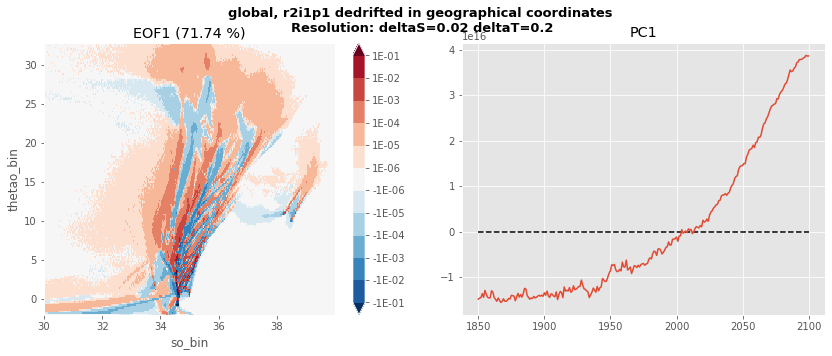

In [99]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1850,2101)

c = eofs_st_1_r2.T.plot(ax=ax[0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_r2))+'%)')
ax[1].plot(time,pcs_r2[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = region+', r2i1p1 dedrifted in geographical coordinates \nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT) # \n centered and reduced'

plt.suptitle(title,fontsize=13,fontweight='bold')

plt.savefig('dedrift_r2i1p1_geographique.png') #002501 #0105

### Dedrift r2i1p1 in T-S space

In [102]:
Vr2 = bin_TS(Sr2,Tr2,dsvol.volcello,sbins,tbins)

In [103]:
covVr2,corVr2,slopeVr2,interceptVr2,pvalVr2,stderrVr2 = lag_linregress_3D(x=Vr2.time,y=Vr2)   

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [104]:
Vr2_dedrift_bis = Vr2 - V_drift + VpiC.mean(dim='time')

In [106]:
Vr2_dedrift_bis = Vr2_dedrift_bis.load()

In [107]:
# -- Perform EOF
solver_r2bis=Eof(Vr2_dedrift_bis.stack(z=('so_bin', 'thetao_bin')))

pcs_r2bis = solver_r2bis.pcs(npcs=3)
eofs_r2bis = solver_r2bis.eofs(neofs=3)
variance_frac_r2bis = solver_r2bis.varianceFraction()
var1_r2bis = variance_frac_r2bis[0].data*100
eofs_st_1_r2bis = eofs_r2bis[0,:].unstack('z')

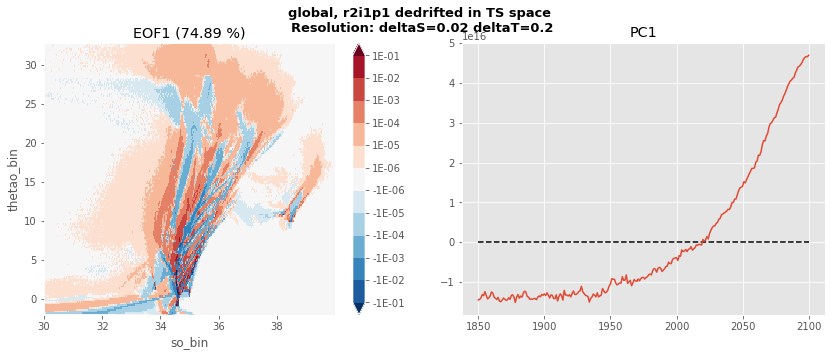

In [108]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1850,2101)

c = eofs_st_1_r2bis.T.plot(ax=ax[0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_r2bis))+'%)')
ax[1].plot(time,pcs_r2bis[:,0])
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = region+', r2i1p1 dedrifted in TS space \nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT) # \n centered and reduced'

plt.suptitle(title,fontsize=13,fontweight='bold')

plt.savefig('dedrift_r2i1p1_TS.png') #002501 #0105

In [110]:
diffvolr2 = Vr2_dedrift_bis.isel(time=-1).sum().data - Vr2_dedrift.isel(time=-1).sum().data

In [113]:
100*diffvolr2/voltot.data

-0.0009615280784956027

In [117]:
100*(vol_mask.sum().data-voltot.data)/voltot.data

0.14653868364386552

In [119]:
(vol_mask.sum().data-voltot.data)/1.e09

1962339.040318464

## Plot drift in T-S 

In [123]:
drift_TS = VpiC - VpiC_dedrift # drift from geographical coordinates

In [125]:
drift_TS = drift_TS.load()

In [126]:
drift_TS_bis = VpiC - VpiC_dedrift_bis # drift from T-S
drift_TS_bis = drift_TS_bis.load()

In [127]:
# -- Perform EOF
solver_drift=Eof(drift_TS.stack(z=('so_bin', 'thetao_bin')))

pcs_drift = solver_drift.pcs(npcs=3)
eofs_drift = solver_drift.eofs(neofs=3)
variance_frac_drift = solver_drift.varianceFraction()
var1_drift = variance_frac_drift[0].data*100
eofs_st_1_drift = eofs_drift[0,:].unstack('z')

In [128]:
# -- Perform EOF
solver_driftbis=Eof(drift_TS_bis.stack(z=('so_bin', 'thetao_bin')))

pcs_driftbis = solver_driftbis.pcs(npcs=3)
eofs_driftbis = solver_driftbis.eofs(neofs=3)
variance_frac_driftbis = solver_driftbis.varianceFraction()
var1_driftbis = variance_frac_driftbis[0].data*100
eofs_st_1_driftbis = eofs_driftbis[0,:].unstack('z')

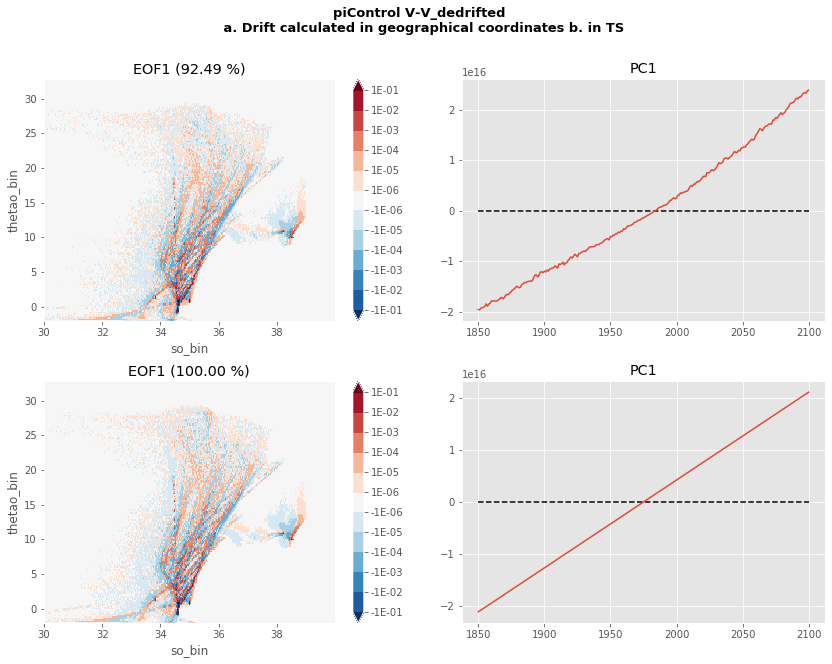

In [130]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(14,10))

time = np.arange(1850,2101)

c = eofs_st_1_drift.T.plot(ax=ax[0,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_drift))+'%)')
ax[0,1].plot(time,pcs_drift[:,0])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')

c = eofs_st_1_driftbis.T.plot(ax=ax[1,0],levels=levels,cmap='RdBu_r',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[1,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[1,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_driftbis))+'%)')
ax[1,1].plot(time,pcs_driftbis[:,0])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC1')

plt.subplots_adjust(hspace=0.25,wspace=0.15)
title = 'piControl V-V_dedrifted \n a. Drift calculated in geographical coordinates b. in TS'

plt.suptitle(title,fontsize=13,fontweight='bold')

plt.savefig('drift_TS_picontrol.png') #002501 #0105